In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:

import os
import re
import string
import numpy as np
import pandas as pd
from numpy import array
from numpy import asarray
from numpy import zeros


from tensorflow.keras.preprocessing.text import Tokenizer, one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences


from sklearn.model_selection import train_test_split
# from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    classification_report, f1_score, precision_score, recall_score,
    confusion_matrix, accuracy_score
)
# from skmultilearn.adapt import MLkNN


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Embedding, LSTM, GRU, SimpleRNN, Dense, Dropout, Activation, Concatenate
)
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.utils import to_categorical


import matplotlib.pyplot as plt
import seaborn as sns



In [42]:
d1= pd.read_csv('/content/drive/MyDrive/NLP_Project/XLM_BiGru_MultiHeadSelfAttention/Hindi/Task-2/Hindi_hate_speech_multi-labeled.csv')
d1


,text,label,defamation,hate,non-hate,violence,vulgar
0,मुझे हिन्दुओं के खिलाफ कुछ नहीं है लेकिन उनमें...,"hate,violence,vulgar,defamation",1,1,0,1,1
1,मैं हर पाकिस्तानी की जिंदगी ख़तम कर दूंगा.,"hate,violence,defamation",1,1,0,1,0
2,सुशांत सिंह राजपूत मामले में रिया चक्रवर्ती से...,non-hate,0,0,1,0,0
3,यह सिर्फ तुम जैसे जिहादी के लिए सामान्य है.,"hate,violence,defamation",1,1,0,1,0
4,देश में कोरोना संक्रमितों की संख्या 42 लाख के ...,non-hate,0,0,1,0,0
...,...,...,...,...,...,...,...
12204,दू हैं या कैसे शांतिपूर्ण तरीके से जीवन व्यतीत...,"defamation,vulgar,violence",1,0,0,1,1
12205,युद्ध घोसना करदेना चाहिए पाकिस्तान के सामने अग...,"defamation,vulgar,violence",1,0,0,1,1
12206,"जीशान खान - कमीने - पाकिस्तानी अभिनेता, क्रिके...","defamation,vulgar,violence",1,0,0,1,1
12207,जीशान खान बहन के लोडो फेसबुक पर ही भौंक सकता ह...,"defamation,vulgar,violence",1,0,0,1,1


In [ ]:
# Word Pre-Processing

def normalize_text(text):
  emoji_pattern = re.compile("["
                              u"\U0001F600-\U0001F64F"  # emoticons
                              u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                              u"\U0001F680-\U0001F6FF"  # transport & map symbols
                              u"\U0001F700-\U0001F77F"  # alchemical symbols
                              u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
                              u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                              u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                              u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                              u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                              u"\U00002702-\U000027B0"  # Dingbats
                              u"\U000024C2-\U0001F251"
                              "]+", flags=re.UNICODE)
  text = text.lower()
  text = re.sub('\[.*?\]', ' ', text)
  text = re.sub('https?://\S+|www\.\S+', ' ', text)
  text = re.sub('<.*?>+', ' ', text)
  text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
  text = re.sub('\n', ' ', text)
  text = re.sub('\w*\d\w*', ' ', text)
  text = re.sub('<handle replaced>', '', text)
  text = emoji_pattern.sub(r'', text)
  return text




In [ ]:
d1['text'] = d1['text'].apply(lambda x: normalize_text(x))
d1

,text,label,defamation,hate,non-hate,violence,vulgar
0,मुझे हिन्दुओं के खिलाफ कुछ नहीं है लेकिन उनमें...,"hate,violence,vulgar,defamation",1,1,0,1,1
1,मैं हर पाकिस्तानी की जिंदगी ख़तम कर दूंगा,"hate,violence,defamation",1,1,0,1,0
2,सुशांत सिंह राजपूत मामले में रिया चक्रवर्ती से...,non-hate,0,0,1,0,0
3,यह सिर्फ तुम जैसे जिहादी के लिए सामान्य है,"hate,violence,defamation",1,1,0,1,0
4,देश में कोरोना संक्रमितों की संख्या लाख के प...,non-hate,0,0,1,0,0
...,...,...,...,...,...,...,...
12204,दू हैं या कैसे शांतिपूर्ण तरीके से जीवन व्यतीत...,"defamation,vulgar,violence",1,0,0,1,1
12205,युद्ध घोसना करदेना चाहिए पाकिस्तान के सामने अग...,"defamation,vulgar,violence",1,0,0,1,1
12206,जीशान खान कमीने पाकिस्तानी अभिनेता क्रिके...,"defamation,vulgar,violence",1,0,0,1,1
12207,जीशान खान बहन के लोडो फेसबुक पर ही भौंक सकता ह...,"defamation,vulgar,violence",1,0,0,1,1


In [ ]:
# Marking as gendered abuse if the record is both hate and vulgar
df=d1
df['gendered_abuse'] = ((df['hate'] == 1) & (df['vulgar'] == 1)).astype(int)
df

,text,label,defamation,hate,non-hate,violence,vulgar,gendered_abuse
0,मुझे हिन्दुओं के खिलाफ कुछ नहीं है लेकिन उनमें...,"hate,violence,vulgar,defamation",1,1,0,1,1,1
1,मैं हर पाकिस्तानी की जिंदगी ख़तम कर दूंगा,"hate,violence,defamation",1,1,0,1,0,0
2,सुशांत सिंह राजपूत मामले में रिया चक्रवर्ती से...,non-hate,0,0,1,0,0,0
3,यह सिर्फ तुम जैसे जिहादी के लिए सामान्य है,"hate,violence,defamation",1,1,0,1,0,0
4,देश में कोरोना संक्रमितों की संख्या लाख के प...,non-hate,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...
12204,दू हैं या कैसे शांतिपूर्ण तरीके से जीवन व्यतीत...,"defamation,vulgar,violence",1,0,0,1,1,0
12205,युद्ध घोसना करदेना चाहिए पाकिस्तान के सामने अग...,"defamation,vulgar,violence",1,0,0,1,1,0
12206,जीशान खान कमीने पाकिस्तानी अभिनेता क्रिके...,"defamation,vulgar,violence",1,0,0,1,1,0
12207,जीशान खान बहन के लोडो फेसबुक पर ही भौंक सकता ह...,"defamation,vulgar,violence",1,0,0,1,1,0


In [ ]:
# value counts of the labels
print(df['gendered_abuse'].value_counts())


gendered_abuse
0    10206
1     2003
Name: count, dtype: int64


In [ ]:
d1_balanced=df[['text','gendered_abuse']]
d1_balanced=d1_balanced.rename(columns={'gendered_abuse': 'label'})
d1_balanced

,text,label
0,मुझे हिन्दुओं के खिलाफ कुछ नहीं है लेकिन उनमें...,1
1,मैं हर पाकिस्तानी की जिंदगी ख़तम कर दूंगा,0
2,सुशांत सिंह राजपूत मामले में रिया चक्रवर्ती से...,0
3,यह सिर्फ तुम जैसे जिहादी के लिए सामान्य है,0
4,देश में कोरोना संक्रमितों की संख्या लाख के प...,0
...,...,...
12204,दू हैं या कैसे शांतिपूर्ण तरीके से जीवन व्यतीत...,0
12205,युद्ध घोसना करदेना चाहिए पाकिस्तान के सामने अग...,0
12206,जीशान खान कमीने पाकिस्तानी अभिनेता क्रिके...,0
12207,जीशान खान बहन के लोडो फेसबुक पर ही भौंक सकता ह...,0


In [ ]:
d1_balanced.head()
d1=d1_balanced

In [ ]:
X1 = list(d1['text'])
y_data1 = d1["label"]

y1 = y_data1.values

print(y1)
print(len(y1))


[1 0 0 ... 0 0 0]
12209


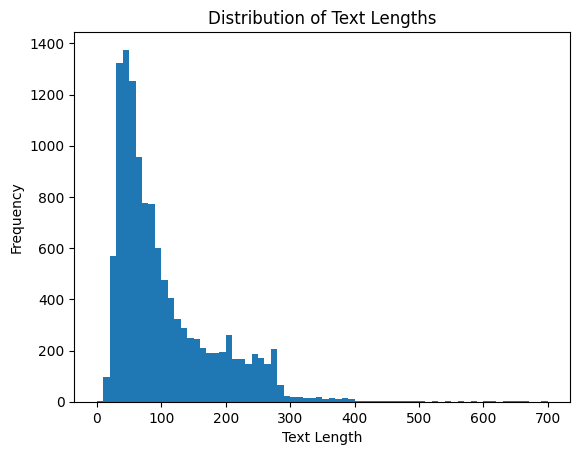

Average Text Length: 103.00270292407241
Length 0-10: 1 1
Length 10-20: 96 97
Length 20-30: 571 668
Length 30-40: 1325 1993
Length 40-50: 1375 3368
Length 50-60: 1253 4621
Length 60-70: 954 5575
Length 70-80: 775 6350
Length 80-90: 771 7121
Length 90-100: 601 7722
Length 100-110: 475 8197
Length 110-120: 407 8604
Length 120-130: 322 8926
Length 130-140: 289 9215
Length 140-150: 249 9464
Length 150-160: 246 9710
Length 160-170: 211 9921
Length 170-180: 189 10110
Length 180-190: 189 10299
Length 190-200: 196 10495
Length 200-210: 262 10757
Length 210-220: 167 10924
Length 220-230: 167 11091
Length 230-240: 146 11237
Length 240-250: 186 11423
Length 250-260: 172 11595
Length 260-270: 146 11741
Length 270-280: 205 11946
Length 280-290: 64 12010
Length 290-300: 22 12032
Length 300-310: 19 12051
Length 310-320: 18 12069
Length 320-330: 15 12084
Length 330-340: 15 12099
Length 340-350: 20 12119
Length 350-360: 12 12131
Length 360-370: 14 12145
Length 370-380: 11 12156
Length 380-390: 14 12170


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


text_lengths = d1['text'].str.len()

# Create a histogram with bins of size 10
plt.hist(text_lengths, bins=range(0, text_lengths.max() + 10, 10))

plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.title('Distribution of Text Lengths')
plt.show()

average_length = text_lengths.mean()
print(f"Average Text Length: {average_length}")


bins = range(0, text_lengths.max() + 10, 10)
counts, _ = np.histogram(text_lengths, bins=bins)

sum=0

for i in range(len(bins) - 1):
    sum+=counts[i]
    print(f"Length {bins[i]}-{bins[i+1]}: {counts[i]} {sum}")

In [7]:
# -*- coding: utf-8 -*-
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Bidirectional, GRU, MultiHeadAttention
from tensorflow.keras.models import Model
from transformers import XLMRobertaTokenizer, TFXLMRobertaModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


# CONFIGURATION

MAX_LEN = 192
BATCH_SIZE = 32
EPOCHS = 5
LEARNING_RATE = 5e-5
VAL_SPLIT = 0.2
CLASS_WEIGHT = {0: 1, 1: 2.5}
XLM_MODEL_NAME = 'xlm-roberta-base'


# MODEL ARCHITECTURE

class XLMRobertaEmbedding(tf.keras.layers.Layer):
    def __init__(self, model_name, **kwargs):
        super().__init__(**kwargs)
        self.xlm_model = TFXLMRobertaModel.from_pretrained(model_name)

    def call(self, inputs):
        input_ids, attention_mask = inputs
        return self.xlm_model(
            input_ids,
            attention_mask=attention_mask,
            return_dict=True
        ).last_hidden_state

def create_model():
    input_ids = Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_ids')
    attention_mask = Input(shape=(MAX_LEN,), dtype=tf.int32, name='attention_mask')

    # XLM-R Embeddings
    embeddings = XLMRobertaEmbedding(XLM_MODEL_NAME)([input_ids, attention_mask])

    # BiGRU with reduced units for English
    gru_out = Bidirectional(GRU(512, return_sequences=True))(embeddings)

    # Multi-Head Attention
    attention = MultiHeadAttention(num_heads=4, key_dim=64)(gru_out, gru_out)

    # Pooling + Classification
    pooled = tf.keras.layers.GlobalAveragePooling1D()(attention)
    dropout = tf.keras.layers.Dropout(0.2)(pooled)
    output = Dense(1, activation='sigmoid')(dropout)

    return Model(inputs=[input_ids, attention_mask], outputs=output)


In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [ ]:

# DATA PREPARATION

# def load_english_data(file_path):
#     df = pd.read_csv(file_path)
#     df['text'] = df['text'].apply(lambda x: x.lower())  # Basic English preprocessing
#     return df


english_df = d1


X_train, X_val, y_train, y_val = train_test_split(
    english_df['text'].values,
    english_df['label'].values,
    test_size=VAL_SPLIT,
    stratify=english_df['label'],
    random_state=42
)

# Tokenization
tokenizer = XLMRobertaTokenizer.from_pretrained(XLM_MODEL_NAME)

def preprocess(texts):
    return tokenizer(
        texts.tolist(),
        max_length=MAX_LEN,
        truncation=True,
        padding='max_length',
        return_tensors='tf'
    )

train_enc = preprocess(X_train)
val_enc = preprocess(X_val)


# MODEL TRAINING

model = create_model()
model.compile(
    optimizer=tf.keras.optimizers.Adam(LEARNING_RATE),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    {'input_ids': train_enc['input_ids'], 'attention_mask': train_enc['attention_mask']},
    y_train,
    validation_data=(
        {'input_ids': val_enc['input_ids'], 'attention_mask': val_enc['attention_mask']},
        y_val
    ),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    class_weight=CLASS_WEIGHT
)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFXLMRobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing TFXLMRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLMRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFXLMRobertaModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMRobertaModel for predictions without further training.


Epoch 1/5
306/306 ━━━━━━━━━━━━━━━━━━━━ 201s 609ms/step - accuracy: 0.8149 - loss: 0.7963 - val_accuracy: 0.8333 - val_loss: 0.4957
Epoch 2/5
306/306 ━━━━━━━━━━━━━━━━━━━━ 206s 622ms/step - accuracy: 0.7952 - loss: 0.7638 - val_accuracy: 0.7916 - val_loss: 0.4928
Epoch 3/5
306/306 ━━━━━━━━━━━━━━━━━━━━ 194s 595ms/step - accuracy: 0.7884 - loss: 0.7305 - val_accuracy: 0.7744 - val_loss: 0.4818
Epoch 4/5
306/306 ━━━━━━━━━━━━━━━━━━━━ 210s 621ms/step - accuracy: 0.7937 - loss: 0.7215 - val_accuracy: 0.7813 - val_loss: 0.4972
Epoch 5/5
306/306 ━━━━━━━━━━━━━━━━━━━━ 202s 622ms/step - accuracy: 0.7823 - loss: 0.7188 - val_accuracy: 0.7584 - val_loss: 0.4986


In [ ]:


# EVALUATION & VISUALIZATION

def evaluate_model(model, data, true_labels):
    y_pred = model.predict(data)
    y_pred_labels = (y_pred > 0.5).astype(int)

    print("\nClassification Report:")
    print(classification_report(true_labels, y_pred_labels))
    print(f"F1 Score: {f1_score(true_labels, y_pred_labels, average='weighted'):.4f}")

print("Hindi Validation Results:")
evaluate_model(model,
    {'input_ids': val_enc['input_ids'], 'attention_mask': val_enc['attention_mask']},
    y_val
)


Hindi Validation Results:
77/77 ━━━━━━━━━━━━━━━━━━━━ 38s 466ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.79      0.85      2041
           1       0.36      0.59      0.44       401

    accuracy                           0.76      2442
   macro avg       0.63      0.69      0.65      2442
weighted avg       0.82      0.76      0.78      2442

F1 Score: 0.7798


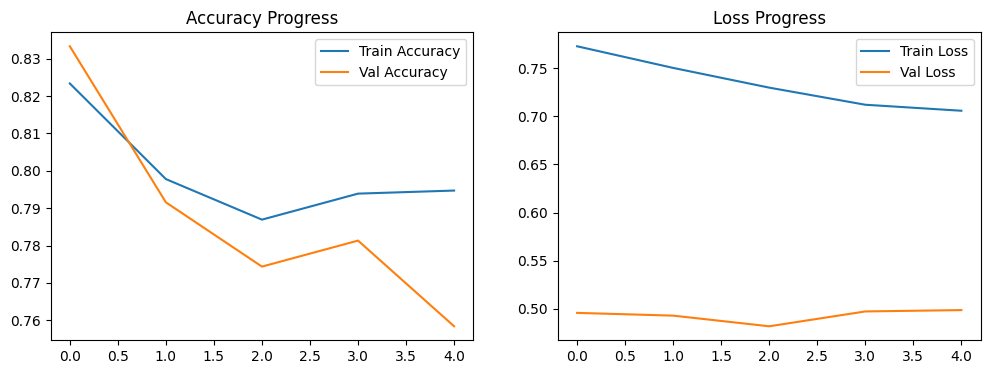

In [ ]:

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy Progress')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Progress')
plt.legend()
plt.show()

In [ ]:
# Save model (TensorFlow SavedModel format)
model.save("/content/drive/MyDrive/NLP_Project/XLM_BiGru_MultiHeadSelfAttention/Hindi/Task-2/Task2_Trained_Model.keras")

# Save tokenizer

from transformers import XLMRobertaTokenizer

# Save tokenizer in a dedicated directory
tokenizer.save_pretrained("/content/drive/MyDrive/NLP_Project/XLM_BiGru_MultiHeadSelfAttention/Hindi/Task-2/Task2_Trained_tokenizer")

('/content/drive/MyDrive/NLP_Project/XLM_BiGru_MultiHeadSelfAttention/Hindi/Task-2/Task2_Trained_tokenizer/tokenizer_config.json',
 '/content/drive/MyDrive/NLP_Project/XLM_BiGru_MultiHeadSelfAttention/Hindi/Task-2/Task2_Trained_tokenizer/special_tokens_map.json',
 '/content/drive/MyDrive/NLP_Project/XLM_BiGru_MultiHeadSelfAttention/Hindi/Task-2/Task2_Trained_tokenizer/sentencepiece.bpe.model',
 '/content/drive/MyDrive/NLP_Project/XLM_BiGru_MultiHeadSelfAttention/Hindi/Task-2/Task2_Trained_tokenizer/added_tokens.json')

# Transfer Learning: Finetuning



In [8]:
import tensorflow as tf
from transformers import XLMRobertaTokenizer

# Load model with custom layer handling
loaded_model = tf.keras.models.load_model(
    "/content/drive/MyDrive/NLP_Project/XLM_BiGru_MultiHeadSelfAttention/Hindi/Task-2/Task2_Trained_Model.keras",
    custom_objects={'XLMRobertaEmbedding': XLMRobertaEmbedding}
)

# Load tokenizer
tokenizer1 = XLMRobertaTokenizer.from_pretrained("/content/drive/MyDrive/NLP_Project/XLM_BiGru_MultiHeadSelfAttention/Hindi/Task-2/Task2_Trained_tokenizer")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFXLMRobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing TFXLMRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLMRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFXLMRobertaModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMRobertaModel for predictions without further training.


In [9]:

# FREEZE LAYERS FOR FINETUNING

print("Freezing the base layers...")

#  model summary to see layer names and structure
print("Model layers:")
for i, layer in enumerate(loaded_model.layers):
    print(f"{i}: {layer.name}")

Freezing the base layers...
Model layers:
0: input_ids
1: attention_mask
2: xlm_roberta_embedding_2
3: bidirectional_2
4: multi_head_attention_2
5: global_average_pooling1d_2
6: dropout_7
7: dense_2


In [10]:
# Freeze XLM-RoBERTa embedding layer
for layer in loaded_model.layers:
    if isinstance(layer, XLMRobertaEmbedding):
        print(f"Freezing layer: {layer.name}")
        layer.trainable = False

Freezing layer: xlm_roberta_embedding_2


In [11]:
new_train_df = pd.read_csv('/content/drive/MyDrive/NLP_Project/NLP/training/train_hi_l1.csv')

# Preprocess the new training data
print("Preprocessing training data...")
def normalize_text(text):
    emoji_pattern = re.compile("["
                              u"\U0001F600-\U0001F64F"  # emoticons
                              u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                              u"\U0001F680-\U0001F6FF"  # transport & map symbols
                              u"\U0001F700-\U0001F77F"  # alchemical symbols
                              u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
                              u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                              u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                              u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                              u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                              u"\U00002702-\U000027B0"  # Dingbats
                              u"\U000024C2-\U0001F251"
                              "]+", flags=re.UNICODE)
    text = str(text).lower()
    text = re.sub('\[.*?\]', ' ', text)
    text = re.sub('https?://\S+|www\.\S+', ' ', text)
    text = re.sub('<.*?>+', ' ', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    text = re.sub('\n', ' ', text)
    text = re.sub('\w*\d\w*', ' ', text)
    text = re.sub('<handle replaced>', '', text)
    text = emoji_pattern.sub(r'', text)
    return text

Preprocessing training data...


In [12]:
new_train_df['text'] = new_train_df['text'].apply(lambda x: normalize_text(x))

# Extract labels from annotation columns
col_lst = ['hi_a1', 'hi_a2', 'hi_a3', 'hi_a4', 'hi_a5']
for col in col_lst:
    new_train_df[col] = pd.to_numeric(new_train_df[col], errors='coerce')

# Use maximum annotation value as the label
new_train_df['label'] = new_train_df[col_lst].max(axis=1, skipna=True).astype(int)
new_train_df = new_train_df[['text', 'label']]

# Check class distribution
print("Class distribution in new training data:")
print(new_train_df['label'].value_counts())

Class distribution in new training data:
label
0    4417
1    1780
Name: count, dtype: int64


In [13]:
# Split new training data
X_finetune, X_val, y_finetune, y_val = train_test_split(
    new_train_df['text'].values,
    new_train_df['label'].values,
    test_size=0.2,
    stratify=new_train_df['label'],
    random_state=42
)

In [19]:
tokenizer11 = XLMRobertaTokenizer.from_pretrained("/content/drive/MyDrive/NLP_Project/XLM_BiGru_MultiHeadSelfAttention/English/task2/Task2_tokenizer")

# Tokenize the new training data
def preprocess(texts):
      return tokenizer1(
          texts.tolist(),
          max_length=MAX_LEN,
          truncation=True,
          padding='max_length',
          return_tensors='tf'
      )

finetune_enc = preprocess(X_finetune)
finetune_val_enc = preprocess(X_val)

In [20]:

# Compile with a lower learning rate for finetuning
loaded_model.compile(
    optimizer=tf.keras.optimizers.Adam(5e-6),  # Even lower learning rate for partial finetuning
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Calculate class weights if imbalanced
unique, counts = np.unique(y_finetune, return_counts=True)
class_weights = {i: len(y_finetune) / (len(unique) * count) for i, count in zip(unique, counts)}
print("Class weights:", class_weights)

Class weights: {np.int64(0): np.float64(0.7015284460798189), np.int64(1): np.float64(1.7405196629213484)}


In [21]:
# Define early stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)

In [22]:
# Finetune the model
finetune_history = loaded_model.fit(
    {'input_ids': finetune_enc['input_ids'], 'attention_mask': finetune_enc['attention_mask']},
    y_finetune,
    validation_data=(
        {'input_ids': finetune_val_enc['input_ids'], 'attention_mask': finetune_val_enc['attention_mask']},
        y_val
    ),
    epochs=5,  # Potentially more epochs but with early stopping
    batch_size=16,  # Smaller batch size for finetuning
    class_weight=class_weights,
    callbacks=[early_stopping]
)

Epoch 1/5
310/310 ━━━━━━━━━━━━━━━━━━━━ 117s 322ms/step - accuracy: 0.5603 - loss: 0.7494 - val_accuracy: 0.4621 - val_loss: 0.7158
Epoch 2/5
310/310 ━━━━━━━━━━━━━━━━━━━━ 142s 330ms/step - accuracy: 0.5006 - loss: 0.6912 - val_accuracy: 0.5226 - val_loss: 0.6840
Epoch 3/5
310/310 ━━━━━━━━━━━━━━━━━━━━ 142s 331ms/step - accuracy: 0.5138 - loss: 0.6887 - val_accuracy: 0.5282 - val_loss: 0.6786
Epoch 4/5
310/310 ━━━━━━━━━━━━━━━━━━━━ 142s 332ms/step - accuracy: 0.5443 - loss: 0.6735 - val_accuracy: 0.5589 - val_loss: 0.6640
Epoch 5/5
310/310 ━━━━━━━━━━━━━━━━━━━━ 145s 342ms/step - accuracy: 0.5492 - loss: 0.6785 - val_accuracy: 0.5685 - val_loss: 0.6573


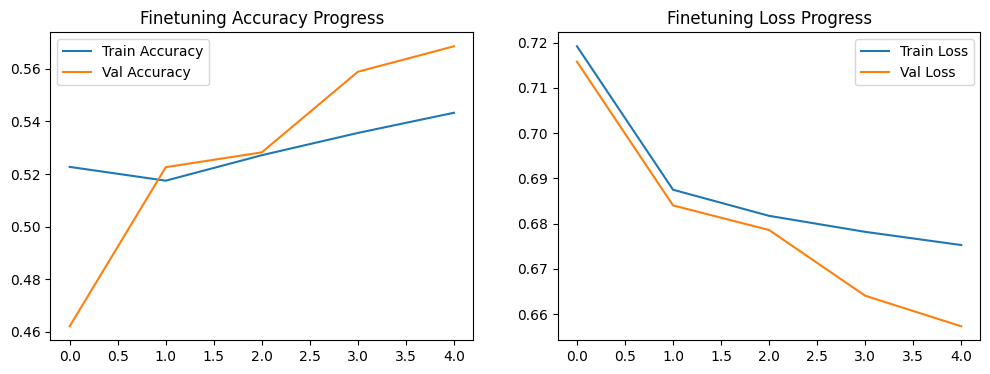

In [23]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(finetune_history.history['accuracy'], label='Train Accuracy')
plt.plot(finetune_history.history['val_accuracy'], label='Val Accuracy')
plt.title('Finetuning Accuracy Progress')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(finetune_history.history['loss'], label='Train Loss')
plt.plot(finetune_history.history['val_loss'], label='Val Loss')
plt.title('Finetuning Loss Progress')
plt.legend()
plt.show()

In [24]:
# Evaluate on validation set
print("Evaluating finetuned model on validation set:")
val_predictions = loaded_model.predict({
    'input_ids': finetune_val_enc['input_ids'],
    'attention_mask': finetune_val_enc['attention_mask']
})
val_binary_preds = (val_predictions > 0.5).astype(int).flatten()
print(classification_report(y_val, val_binary_preds))

Evaluating finetuned model on validation set:
39/39 ━━━━━━━━━━━━━━━━━━━━ 22s 500ms/step
              precision    recall  f1-score   support

           0       0.75      0.60      0.66       884
           1       0.33      0.50      0.40       356

    accuracy                           0.57      1240
   macro avg       0.54      0.55      0.53      1240
weighted avg       0.63      0.57      0.59      1240



In [28]:
# Save the finetuned model
loaded_model.save("/content/drive/MyDrive/NLP_Project/XLM_BiGru_MultiHeadSelfAttention/Hindi/Task-2/Task2_Model_Finetuned.keras")
print("Finetuned model saved!")
tokenizer1.save_pretrained("/content/drive/MyDrive/NLP_Project/XLM_BiGru_MultiHeadSelfAttention/Hindi/Task-2/Task2_Trained_tokenizer")


Finetuned model saved!


('/content/drive/MyDrive/NLP_Project/XLM_BiGru_MultiHeadSelfAttention/Hindi/Task-2/Task2_Trained_tokenizer/tokenizer_config.json',
 '/content/drive/MyDrive/NLP_Project/XLM_BiGru_MultiHeadSelfAttention/Hindi/Task-2/Task2_Trained_tokenizer/special_tokens_map.json',
 '/content/drive/MyDrive/NLP_Project/XLM_BiGru_MultiHeadSelfAttention/Hindi/Task-2/Task2_Trained_tokenizer/sentencepiece.bpe.model',
 '/content/drive/MyDrive/NLP_Project/XLM_BiGru_MultiHeadSelfAttention/Hindi/Task-2/Task2_Trained_tokenizer/added_tokens.json')

testing


In [32]:
import tensorflow as tf
from transformers import XLMRobertaTokenizer

# Load model with custom layer handling
loaded_model = tf.keras.models.load_model(
    "/content/drive/MyDrive/NLP_Project/XLM_BiGru_MultiHeadSelfAttention/Hindi/Task-2/Task2_Model_Finetuned.keras",
    custom_objects={'XLMRobertaEmbedding': XLMRobertaEmbedding}
)

# Load tokenizer
tokenizer1 = XLMRobertaTokenizer.from_pretrained("/content/drive/MyDrive/NLP_Project/XLM_BiGru_MultiHeadSelfAttention/Hindi/Task-2/Task2_Trained_tokenizer")

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFXLMRobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing TFXLMRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLMRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFXLMRobertaModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMRobertaModel for predictions without further training.


In [33]:
vv_1= pd.read_csv('/content/drive/MyDrive/NLP_Project/NLP/testing/hindi/test_hi_l1.csv')
vv1=vv_1


In [34]:
vv_1['text'] = vv_1['text'].apply(lambda x: normalize_text(x))

# vv['text'] = vv['text'].apply(lambda x: normalize_text_2(x))
vv_1 = vv_1[['text']]

vv_1.columns = ['text']
vv_1

,text
0,bandrastation sharadpawar muradabad अगर अभ...
1,conspiracyagainstindia सुन लो रे देश के गद्द...
2,marathareservation महाराष्ट्र में जश्न का म...
3,rheachakraborty aap mahesh bhatt se madad kiy...
4,secularmaskofd हमे पता नहि क्या कहते है इतना...
...,...
1512,है हैवान लोग होते हैं इनको ओसामा लादेन खतरनाक ...
1513,जय हिन्द जय भारत वन्दे मातरम बघेल तुझसे देश शर...
1514,जय भीम जो लोग हमें धमकियां देते है और संविध...
1515,इंसान के पास दिमाग होना चाहिये खोपड़ी तो ...


In [35]:
# X = list(vv1['text'])
#y = np.asarray(d1[d1.columns[1:]])
col_lst = ['hi_a1', 'hi_a2', 'hi_a3', 'hi_a4', 'hi_a5']
for col in col_lst:
    vv1[col] = pd.to_numeric(vv1[col], errors='coerce')


# vv1['label'] = vv1[col_lst].max(axis=1, skipna=True).astype(int)  # skipna=True to ignore empty values

# Take max across non-NaN, non-inf annotator labels
vv1['label'] = vv1[col_lst].max(axis=1, skipna=True)

# Replace remaining NaN (e.g., if all annotators were missing or invalid) with 0
vv1['label'] = vv1['label'].fillna(0).astype(int)

# vv1['label'] = vv1['label'].astype(int)


vv1 = vv1[['label', 'text']]


true_1 = vv1["label"]

# print(true_)
y_test_1 = true_1.values

print(y_test_1)
print(len(y_test_1))

[0 0 0 ... 0 0 1]
1517


In [36]:
X_test=vv1['text'].values
y_test=vv1['label'].values

In [37]:
# sequence1 = tokenizer1.texts_to_sequences(vv_1['text']) # same tokenizer which is used on train data.

def preprocess(texts):
    return tokenizer1(
        texts.tolist(),
        max_length=MAX_LEN,
        truncation=True,
        padding='max_length',
        return_tensors='tf'
    )

In [38]:
test_enc = preprocess(X_test)


Test Set Evaluation:
48/48 ━━━━━━━━━━━━━━━━━━━━ 24s 462ms/step

Best Threshold: 0.3268
              precision    recall  f1-score   support

     Neutral       0.80      0.18      0.29       829
       Abuse       0.49      0.95      0.64       688

    accuracy                           0.53      1517
   macro avg       0.64      0.56      0.47      1517
weighted avg       0.66      0.53      0.45      1517

Weighted F1: 0.4508


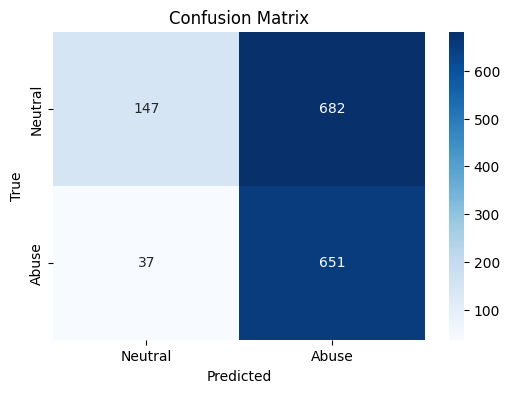

In [39]:
from sklearn.metrics import classification_report, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_curve


# PREDICTION & EVALUATION

def evaluate_model(model, data, true_labels):
    # Get predictions
    y_pred_probs = model.predict({
        'input_ids': data['input_ids'],
        'attention_mask': data['attention_mask']
    })

    # Find optimal threshold
    precision, recall, thresholds = precision_recall_curve(true_labels, y_pred_probs)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)
    best_threshold = thresholds[np.argmax(f1_scores)]

    # Apply threshold
    y_pred = (y_pred_probs > best_threshold).astype(int)

    # Metrics
    print(f"\nBest Threshold: {best_threshold:.4f}")
    print(classification_report(true_labels, y_pred, target_names=['Neutral', 'Abuse']))
    print(f"Weighted F1: {f1_score(true_labels, y_pred, average='weighted'):.4f}")

    # Confusion Matrix
    cm = confusion_matrix(true_labels, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Neutral', 'Abuse'],
                yticklabels=['Neutral', 'Abuse'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

print("Test Set Evaluation:")
evaluate_model(loaded_model, test_enc, y_test)



In [40]:
from sklearn.metrics import classification_report, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_curve




# SAMPLE PREDICTIONS

def show_predictions(texts, labels, num_samples=5):
    indices = np.random.choice(len(texts), num_samples, replace=False)
    for idx in indices:
        text = texts[idx]
        true_label = labels[idx]

        inputs = tokenizer1(
            text,
            max_length=MAX_LEN,
            truncation=True,
            padding='max_length',
            return_tensors='tf'
        )
        pred_prob = loaded_model.predict([inputs['input_ids'], inputs['attention_mask']])[0][0]
        pred_label = "Abuse" if pred_prob > 0.5 else "Neutral"

        print(f"\nText: {text[:100]}...")
        print(f"True: {true_label} | Predicted: {pred_label} ({pred_prob:.4f})")

print("\nSample Predictions:")
show_predictions(X_test, y_test)


Sample Predictions:
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step

Text:  औरते नही बीबी     महिलाएं    क्योंकि औरत तो      ...
True: 1 | Predicted: Abuse (0.6038)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step

Text: फिसल गया मादरचोद...
True: 1 | Predicted: Neutral (0.3601)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step

Text:  आसिम घटिया को जंगल में वापस भेजा दीजिए  जंगली जानवरों की बिग बॉस में कोई जरूरत नहीं  stoptargetings...
True: 0 | Predicted: Neutral (0.4907)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step

Text:  आपने सही कहा यह दलाल है मीडिया नहीं है...
True: 1 | Predicted: Neutral (0.3827)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step

Text: सुशांत केस में बिहार पुलिस के हाथ लगे ये अहम सुराग  रिया पर कसा जा सकता था शिकंजा   rheachakraborty ...
True: 0 | Predicted: Neutral (0.3879)
